# Calculate Stats on Tuning Distributions

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scikit_posthocs as posthoc
from statsmodels.stats.multitest import multipletests

sys.path.insert(0, os.path.abspath(r'C:/Users/mmccann/repos/bonhoeffer/prey_capture/'))
import functions_plotting as fp

In [2]:
def h5_to_dict(filepath):
    with pd.HDFStore(filepath, 'r') as store:
        keys = store.keys()
        data = {key[1:]: store[key] for key in keys}
    return data


def kruskal_w_dunn(data, nan_policy='omit', alpha=0.05):
    statistic, p_val = stats.kruskal(*data, nan_policy=nan_policy)
    dunn_test = posthoc.posthoc_dunn([*data], p_adjust='holm')
    return p_val, dunn_test


def mannwhitneyu_w_bonferroni(data, nan_policy='omit', alpha=0.05):
    statistic, p_val = stats.mannwhitneyu(*data, nan_policy=nan_policy)
    reject, p_val_corrected, _, _ = multipletests(p_val, alpha=alpha, method='holm')
    return p_val, p_val_corrected


def wilcoxon_w_bonferroni(data, nan_policy='omit', alpha=0.05):
    statistic, p_val = stats.wilcoxon(*data, nan_policy=nan_policy)
    reject, p_val_corrected, _, _ = multipletests(p_val, alpha=alpha, method='holm')
    return p_val, p_val_corrected


def sample_df(data1, data2):
    df1 = data1.dropna()
    df2 = data2.dropna() 

    if len(df1) > len(df2):
        df1 = df1.sample(len(df2))
    elif len(df2) > len(df1):
        df2 = df2.sample(len(df1))
    else:
        pass

    return df1, df2


def bootstrap_tests(data, method, n_iters=10000, alpha=0.05, bootstrap_all=False):

    # First run the test on the raw data
    if 'wilcoxon' in method.__name__:
        raw_test = method(sample_df(*data), alpha=alpha)
    else:
        raw_test = method(data, alpha=alpha)

    # Now run the bootstrapping
    p_vals = np.zeros(n_iters)
    p_vals_corrected = []

    sample_size = max([len(d) for d in data])

    # Run bootstrap
    for i in range(n_iters):

        if bootstrap_all:
            sample_data = [d.sample(sample_size, replace=True) for d in data]
        else:
            sample_data = [data[0].sample(n=sample_size, replace=False)] + [d.sample(n=sample_size, replace=True) for d in data[1:]]
            
        p_val, p_val_corrected = method(sample_data, alpha=alpha)
        p_vals[i] = p_val
        p_vals_corrected.append(p_val_corrected)

    # 95% confidence interval
    ci = stats.t.interval(0.95, len(p_vals) - 1, loc=np.nanmean(p_vals), scale=stats.sem(p_vals, nan_policy='omit'))

    if method == kruskal_w_dunn:
        ci_corrected = None
    else:
        ci_corrected = stats.t.interval(0.95, len(p_vals_corrected) - 1, loc=np.nanmean(p_vals_corrected), scale=stats.sem(p_vals_corrected, nan_policy='omit'))

    return raw_test, (p_vals, ci, p_vals_corrected, ci_corrected)


In [3]:
main_exp_path = r"Z:\Prey_capture\WF_Figures\multi_normal_ALL\stats.hdf5"
control_light_path  = r"Z:\Prey_capture\WF_Figures\control_normal_ALL\stats.hdf5"
control_dark_path = r"Z:\Prey_capture\WF_Figures\control_dark_ALL\stats.hdf5"
repeat_fixed_path = r"Z:\Prey_capture\WF_Figures\repeat_normal_VWheelWF\stats.hdf5"
repeat_free_path = r"Z:\Prey_capture\WF_Figures\repeat_normal_VTuningWF\stats.hdf5"

In [4]:
main_exp_data = h5_to_dict(main_exp_path)
control_light_data = h5_to_dict(control_light_path)
control_dark_data = h5_to_dict(control_dark_path)
repeat_fixed_data = h5_to_dict(repeat_fixed_path)
repeat_free_data = h5_to_dict(repeat_free_path)

# Visual Tuning

In [10]:
method = mannwhitneyu_w_bonferroni
bootstrap_iters = 10000

## Frac Visual Tuning - Fixed to Free

In [6]:
# Do a Kruskal-Wallis test with posthoc Dunn test for multiple comparisons
exp_fixed_free_vis = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].visual, main_exp_data['frac_vis_resp_free'].visual))
print('Fixed vs Free Visual:', exp_fixed_free_vis)

exp_fixed_free_ori = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].orientation, main_exp_data['frac_vis_resp_free'].orientation))
print('Fixed vs Free Orientation:', exp_fixed_free_ori)

exp_fixed_free_dir = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].direction, main_exp_data['frac_vis_resp_free'].direction))
print('Fixed vs Free Direction:', exp_fixed_free_dir)

Fixed vs Free Visual: (0.02716595157563186,           1         2
1  1.000000  0.027166
2  0.027166  1.000000)
Fixed vs Free Orientation: (0.8928166164345637,           1         2
1  1.000000  0.892817
2  0.892817  1.000000)
Fixed vs Free Direction: (0.9684170147133586,           1         2
1  1.000000  0.968417
2  0.968417  1.000000)


In [8]:
# Do a Wilcox Rank-Sum test with Bonferroni correction
exp_fixed_free_vis = wilcoxon_w_bonferroni(sample_df(main_exp_data['frac_vis_resp_fixed'].visual, main_exp_data['frac_vis_resp_free'].visual))
print('Fixed vs Free Visual:', exp_fixed_free_vis)

exp_fixed_free_ori = wilcoxon_w_bonferroni(sample_df(main_exp_data['frac_vis_resp_fixed'].orientation, main_exp_data['frac_vis_resp_free'].orientation))
print('Fixed vs Free Orientation:', exp_fixed_free_ori)

exp_fixed_free_dir = wilcoxon_w_bonferroni(sample_df(main_exp_data['frac_vis_resp_fixed'].direction, main_exp_data['frac_vis_resp_free'].direction))
print('Fixed vs Free Direction:', exp_fixed_free_dir)

Fixed vs Free Visual: (0.020132923808300392, array([0.02013292]))
Fixed vs Free Orientation: (0.46432199762123494, array([0.464322]))
Fixed vs Free Direction: (0.7409101444898674, array([0.74091014]))


In [9]:
# Do a Mann-Whitney U test with Bonferroni correction
exp_fixed_free_vis = mannwhitneyu_w_bonferroni([main_exp_data['frac_vis_resp_fixed'].visual.dropna(), 
                                               main_exp_data['frac_vis_resp_free'].visual.dropna()])
print('Fixed vs Free Visual:', exp_fixed_free_vis)

exp_fixed_free_ori = mannwhitneyu_w_bonferroni([main_exp_data['frac_vis_resp_fixed'].orientation.dropna(), 
                                               main_exp_data['frac_vis_resp_free'].orientation.dropna()])
print('Fixed vs Free Orientation:', exp_fixed_free_ori)

exp_fixed_free_dir = mannwhitneyu_w_bonferroni([main_exp_data['frac_vis_resp_fixed'].direction.dropna(), 
                                               main_exp_data['frac_vis_resp_free'].direction.dropna()])
print('Fixed vs Free Direction:', exp_fixed_free_dir)

Fixed vs Free Visual: (0.027260800788819466, array([0.0272608]))
Fixed vs Free Orientation: (0.986249049450832, array([0.98624905]))
Fixed vs Free Direction: (0.9479327534941364, array([0.94793275]))


## Frac Visual Tuning - Exp vs Controls

### Fixed Kruskal Wallis

In [ ]:
frac_fixed_vis = bootstrap_tests([main_exp_data['frac_vis_resp_fixed'].visual.dropna(), 
                                  control_light_data['frac_vis_resp_fixed'].visual.dropna(), 
                                  control_dark_data['frac_vis_resp_fixed'].visual.dropna()],
                                  kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)

frac_fixed_ori = bootstrap_tests([main_exp_data['frac_vis_resp_fixed'].orientation.dropna(), 
                                  control_light_data['frac_vis_resp_fixed'].orientation.dropna(), 
                                  control_dark_data['frac_vis_resp_fixed'].orientation.dropna()],
                                  kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)

frac_fixed_dir = bootstrap_tests([main_exp_data['frac_vis_resp_fixed'].direction.dropna(), 
                                  control_light_data['frac_vis_resp_fixed'].direction.dropna(), 
                                  control_dark_data['frac_vis_resp_fixed'].direction.dropna()],
                                  kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)

frac_free_vis = bootstrap_tests([main_exp_data['frac_vis_resp_free'].visual.dropna(), 
                                control_light_data['frac_vis_resp_free'].visual.dropna(), 
                                control_dark_data['frac_vis_resp_free'].visual.dropna()],
                                kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)

frac_free_ori = bootstrap_tests([main_exp_data['frac_vis_resp_free'].orientation.dropna(), 
                                control_light_data['frac_vis_resp_free'].orientation.dropna(), 
                                control_dark_data['frac_vis_resp_free'].orientation.dropna()],
                                kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)

frac_free_dir = bootstrap_tests([main_exp_data['frac_vis_resp_free'].direction.dropna(), 
                                control_light_data['frac_vis_resp_free'].direction.dropna(), 
                                control_dark_data['frac_vis_resp_free'].direction.dropna()],
                                kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)

### Fixed

Fixed vs Control Light Visual p: (0.10925108128292178, array([0.10925108]))
Fixed vs Control Light Visual Bootstrap CI: (0.015006639235785556, 0.017318605989332134)
Fixed vs Control Light Orientation p: (0.6764556907342165, array([0.67645569]))
Fixed vs Control Light Orientation Bootstrap CI: (0.3850434461675639, 0.39690188470221166)
Fixed vs Control Light Direction p: (0.7984903130750975, array([0.79849031]))
Fixed vs Control Light Direction Bootstrap CI: (0.4296103561634801, 0.44139104979035826)


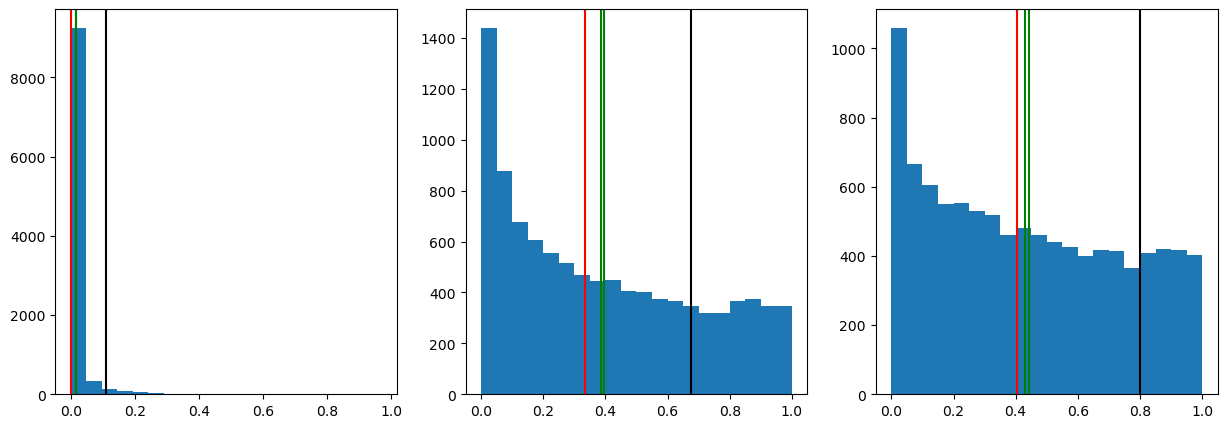

In [12]:
# Exp vs control light
frac_fixed_exp_control_light_vis, bs_frac_fixed_exp_control_light_vis = \
    bootstrap_tests([main_exp_data['frac_vis_resp_fixed'].visual.dropna(), control_light_data['frac_vis_resp_fixed'].visual.dropna()], 
                    method, n_iters=bootstrap_iters, bootstrap_all=True)

print('Fixed vs Control Light Visual p:', frac_fixed_exp_control_light_vis)
print('Fixed vs Control Light Visual Bootstrap CI:', bs_frac_fixed_exp_control_light_vis[1])

frac_fixed_exp_control_light_ori , bs_frac_fixed_exp_control_light_ori = \
    bootstrap_tests([main_exp_data['frac_vis_resp_fixed'].orientation.dropna(), control_light_data['frac_vis_resp_fixed'].orientation.dropna()], 
                     method, n_iters=bootstrap_iters, bootstrap_all=True)

print('Fixed vs Control Light Orientation p:', frac_fixed_exp_control_light_ori)
print('Fixed vs Control Light Orientation Bootstrap CI:', bs_frac_fixed_exp_control_light_ori[1])

frac_fixed_exp_control_light_dir, bs_frac_fixed_exp_control_light_dir = \
    bootstrap_tests([main_exp_data['frac_vis_resp_fixed'].direction.dropna(), control_light_data['frac_vis_resp_fixed'].direction.dropna()], 
                    method, n_iters=bootstrap_iters, bootstrap_all=True)

print('Fixed vs Control Light Direction p:', frac_fixed_exp_control_light_dir)
print('Fixed vs Control Light Direction Bootstrap CI:', bs_frac_fixed_exp_control_light_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_frac_fixed_exp_control_light_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_frac_fixed_exp_control_light_vis[0], 50), 0, 100, color='r')
ax[0].axvline(frac_fixed_exp_control_light_vis[0], 0, 100, color='k')
ax[0].axvline(bs_frac_fixed_exp_control_light_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_frac_fixed_exp_control_light_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_frac_fixed_exp_control_light_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_frac_fixed_exp_control_light_ori[0], 50), 0, 100, color='r')
ax[1].axvline(frac_fixed_exp_control_light_ori[0], 0, 100, color='k')
ax[1].axvline(bs_frac_fixed_exp_control_light_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_frac_fixed_exp_control_light_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_frac_fixed_exp_control_light_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_frac_fixed_exp_control_light_dir[0], 50), 0, 100, color='r')
ax[2].axvline(frac_fixed_exp_control_light_dir[0], 0, 100, color='k')
ax[2].axvline(bs_frac_fixed_exp_control_light_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_frac_fixed_exp_control_light_dir[1][1], 0, 100, color='g')

In [ ]:
# Exp vs control dark
frac_fixed_exp_control_dark_vis, bs_frac_fixed_exp_control_dark_vis = \
    bootstrap_tests([main_exp_data['frac_vis_resp_fixed'].visual.dropna(), control_dark_data['frac_vis_resp_fixed'].visual.dropna()], 
                    method, n_iters=bootstrap_iters, bootstrap_all=False)

print('Fixed vs Control Dark Visual p:', frac_fixed_exp_control_dark_vis)
print('Fixed vs Control Dark Visual Bootstrap CI:', bs_frac_fixed_exp_control_dark_vis[1])

frac_fixed_exp_control_dark_ori , bs_frac_fixed_exp_control_dark_ori = \
    bootstrap_tests([main_exp_data['frac_vis_resp_fixed'].orientation.dropna(), control_dark_data['frac_vis_resp_fixed'].orientation.dropna()], 
                    method, n_iters=bootstrap_iters, bootstrap_all=False)

print('Fixed vs Control Dark Orientation p:', frac_fixed_exp_control_dark_ori)
print('Fixed vs Control Dark Orientation Bootstrap CI:', bs_frac_fixed_exp_control_dark_ori[1])

frac_fixed_exp_control_dark_dir, bs_frac_fixed_exp_control_dark_dir = \
    bootstrap_tests([main_exp_data['frac_vis_resp_fixed'].direction.dropna(), control_dark_data['frac_vis_resp_fixed'].direction.dropna()], 
                    method, n_iters=bootstrap_iters, bootstrap_all=False)

print('Fixed vs Control Dark Direction p:', frac_fixed_exp_control_dark_dir)
print('Fixed vs Control Dark Direction Bootstrap CI:', bs_frac_fixed_exp_control_dark_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_frac_fixed_exp_control_dark_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_frac_fixed_exp_control_dark_vis[0], 50), 0, 100, color='r')
ax[0].axvline(frac_fixed_exp_control_dark_vis[2], 0, 100, color='k')
ax[0].axvline(bs_frac_fixed_exp_control_dark_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_frac_fixed_exp_control_dark_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_frac_fixed_exp_control_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_frac_fixed_exp_control_dark_ori[0], 50), 0, 100, color='r')
ax[1].axvline(frac_fixed_exp_control_dark_ori[2], 0, 100, color='k')
ax[1].axvline(bs_frac_fixed_exp_control_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_frac_fixed_exp_control_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_frac_fixed_exp_control_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_frac_fixed_exp_control_dark_dir[0], 50), 0, 100, color='r')
ax[2].axvline(frac_fixed_exp_control_dark_dir[2], 0, 100, color='k')
ax[2].axvline(bs_frac_fixed_exp_control_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_frac_fixed_exp_control_dark_dir[1][1], 0, 100, color='g')

In [ ]:
# Control light vs control dark
frac_fixed_control_light_dark_vis, bs_frac_fixed_control_light_dark_vis = run_bootstrap_tests(control_light_data['frac_vis_resp_fixed'].visual.dropna(), 
                                                                                              control_dark_data['frac_vis_resp_fixed'].visual.dropna(), 
                                                                                              method, n_iters=bootstrap_iters, bootstrap_all=False)

print('Control Light vs Control Dark Visual p:', frac_fixed_control_light_dark_vis)
print('Control Light vs Control Dark Visual Bootstrap CI:', bs_frac_fixed_control_light_dark_vis[1])

frac_fixed_control_light_dark_ori , bs_frac_fixed_control_light_dark_ori = run_bootstrap_tests(control_light_data['frac_vis_resp_fixed'].orientation.dropna(), 
                                                                                               control_dark_data['frac_vis_resp_fixed'].orientation.dropna(), 
                                                                                               method, n_iters=bootstrap_iters, bootstrap_all=False)
print('Control Light vs Control Dark Orientation p:', frac_fixed_control_light_dark_ori)
print('Control Light vs Control Dark Orientation Bootstrap CI:', bs_frac_fixed_control_light_dark_ori[1])

frac_fixed_control_light_dark_dir, bs_frac_fixed_control_light_dark_dir = run_bootstrap_tests(control_light_data['frac_vis_resp_fixed'].direction.dropna(), 
                                                                                              control_dark_data['frac_vis_resp_fixed'].direction.dropna(), 
                                                                                              method, n_iters=bootstrap_iters, bootstrap_all=False)
print('Control Light vs Control Dark Direction p:', frac_fixed_control_light_dark_dir)
print('Control Light vs Control Dark Direction Bootstrap CI:', bs_frac_fixed_control_light_dark_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_frac_fixed_control_light_dark_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_frac_fixed_control_light_dark_vis[0], 50), 0, 100, color='r')
ax[0].axvline(frac_fixed_control_light_dark_vis[2], 0, 100, color='k')
ax[0].axvline(bs_frac_fixed_control_light_dark_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_frac_fixed_control_light_dark_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_frac_fixed_control_light_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_frac_fixed_control_light_dark_ori[0], 50), 0, 100, color='r')
ax[1].axvline(frac_fixed_control_light_dark_ori[2], 0, 100, color='k')
ax[1].axvline(bs_frac_fixed_control_light_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_frac_fixed_control_light_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_frac_fixed_control_light_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_frac_fixed_control_light_dark_dir[0], 50), 0, 100, color='r')
ax[2].axvline(frac_fixed_control_light_dark_dir[2], 0, 100, color='k')
ax[2].axvline(bs_frac_fixed_control_light_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_frac_fixed_control_light_dark_dir[1][1], 0, 100, color='g')

### Free

In [ ]:
# Exp vs control light
frac_free_exp_control_light_vis, bs_frac_free_exp_control_light_vis = run_bootstrap_tests(main_exp_data['frac_vis_resp_free'].visual.dropna(), 
                                                                                          control_light_data['frac_vis_resp_free'].visual.dropna(), 
                                                                                          method, n_iters=bootstrap_iters, bootstrap_both=False)

print('Free vs Control Light Visual p:', frac_free_exp_control_light_vis)
print(f'Free vs Control Light Visual Bootstrap CI: {bs_frac_free_exp_control_light_vis[1]}\n')

frac_free_exp_control_light_ori , bs_frac_free_exp_control_light_ori = run_bootstrap_tests(main_exp_data['frac_vis_resp_free'].orientation.dropna(), 
                                                                                           control_light_data['frac_vis_resp_free'].orientation.dropna(), 
                                                                                           method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Light Orientation p:', frac_free_exp_control_light_ori)
print(f'Free vs Control Light Orientation Bootstrap CI: {bs_frac_free_exp_control_light_ori[1]}\n')

frac_free_exp_control_light_dir, bs_frac_free_exp_control_light_dir = run_bootstrap_tests(main_exp_data['frac_vis_resp_free'].direction.dropna(), 
                                                                                          control_light_data['frac_vis_resp_free'].direction.dropna(), 
                                                                                          method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Light Direction p:', frac_free_exp_control_light_dir)
print(f'Free vs Control Light Direction Bootstrap CI: {bs_frac_free_exp_control_light_dir[1]}\n')

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_frac_free_exp_control_light_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_frac_free_exp_control_light_vis[0], 50), 0, 100, color='r')
ax[0].axvline(frac_free_exp_control_light_vis[2], 0, 100, color='k')
ax[0].axvline(bs_frac_free_exp_control_light_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_frac_free_exp_control_light_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_frac_free_exp_control_light_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_frac_free_exp_control_light_ori[0], 50), 0, 100, color='r')
ax[1].axvline(frac_free_exp_control_light_ori[2], 0, 100, color='k')
ax[1].axvline(bs_frac_free_exp_control_light_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_frac_free_exp_control_light_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_frac_free_exp_control_light_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_frac_free_exp_control_light_dir[0], 50), 0, 100, color='r')
ax[2].axvline(frac_free_exp_control_light_dir[2], 0, 100, color='k')
ax[2].axvline(bs_frac_free_exp_control_light_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_frac_free_exp_control_light_dir[1][1], 0, 100, color='g')

In [ ]:
# Exp vs control light
frac_free_exp_control_dark_vis, bs_frac_free_exp_control_dark_vis = run_bootstrap_tests(main_exp_data['frac_vis_resp_free'].visual.dropna(), 
                                                                                        control_dark_data['frac_vis_resp_free'].visual.dropna(), 
                                                                                        method, n_iters=bootstrap_iters, bootstrap_both=False)

print('Free vs Control Dark Visual p:', frac_free_exp_control_dark_vis)
print(f'Free vs Control Light Visual Bootstrap CI: {bs_frac_free_exp_control_dark_vis[1]}\n')

frac_free_exp_control_dark_ori , bs_frac_free_exp_control_dark_ori = run_bootstrap_tests(main_exp_data['frac_vis_resp_free'].orientation.dropna(), 
                                                                                         control_dark_data['frac_vis_resp_free'].orientation.dropna(), 
                                                                                         method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Dark Orientation p:', frac_free_exp_control_dark_ori)
print(f'Free vs Control Dark Orientation Bootstrap CI: {bs_frac_free_exp_control_dark_ori[1]}\n')

frac_free_exp_control_dark_dir, bs_frac_free_exp_control_dark_dir = run_bootstrap_tests(main_exp_data['frac_vis_resp_free'].direction.dropna(), 
                                                                                        control_dark_data['frac_vis_resp_free'].direction.dropna(), 
                                                                                        method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Dark Direction p:', frac_free_exp_control_dark_dir)
print(f'Free vs Control Dark Direction Bootstrap CI: {bs_frac_free_exp_control_dark_dir[1]}\n')

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_frac_free_exp_control_dark_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_frac_free_exp_control_dark_vis[0], 50), 0, 100, color='r')
ax[0].axvline(frac_free_exp_control_dark_vis[2], 0, 100, color='k')
ax[0].axvline(bs_frac_free_exp_control_dark_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_frac_free_exp_control_dark_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_frac_free_exp_control_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_frac_free_exp_control_dark_ori[0], 50), 0, 100, color='r')
ax[1].axvline(frac_free_exp_control_dark_ori[2], 0, 100, color='k')
ax[1].axvline(bs_frac_free_exp_control_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_frac_free_exp_control_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_frac_free_exp_control_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_frac_free_exp_control_dark_dir[0], 50), 0, 100, color='r')
ax[2].axvline(frac_free_exp_control_dark_dir[2], 0, 100, color='k')
ax[2].axvline(bs_frac_free_exp_control_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_frac_free_exp_control_dark_dir[1][1], 0, 100, color='g')

In [ ]:
# Control light vs control dark
frac_free_control_light_dark_vis, bs_frac_free_control_light_dark_vis = run_bootstrap_tests(control_light_data['frac_vis_resp_free'].visual.dropna(), 
                                                                                            control_dark_data['frac_vis_resp_free'].visual.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)

print('Control Light vs Control Dark Visual p:', frac_free_control_light_dark_vis)
print('Control Light vs Control Dark Visual Bootstrap CI:', bs_frac_free_control_light_dark_vis[1])

frac_free_control_light_dark_ori , bs_frac_free_control_light_dark_ori = run_bootstrap_tests(control_light_data['frac_vis_resp_free'].orientation.dropna(), 
                                                                                            control_dark_data['frac_vis_resp_free'].orientation.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Orientation p:', frac_free_control_light_dark_ori)
print('Control Light vs Control Dark Orientation Bootstrap CI:', bs_frac_free_control_light_dark_ori[1])

frac_free_control_light_dark_dir, bs_frac_free_control_light_dark_dir = run_bootstrap_tests(control_light_data['frac_vis_resp_free'].direction.dropna(), 
                                                                                            control_dark_data['frac_vis_resp_free'].direction.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Direction p:', frac_free_control_light_dark_dir)
print('Control Light vs Control Dark Direction Bootstrap CI:', bs_frac_free_control_light_dark_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_frac_free_control_light_dark_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_frac_free_control_light_dark_vis[0], 50), 0, 100, color='r')
ax[0].axvline(frac_free_control_light_dark_vis[2], 0, 100, color='k')
ax[0].axvline(bs_frac_free_control_light_dark_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_frac_free_control_light_dark_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_frac_free_control_light_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_frac_free_control_light_dark_ori[0], 50), 0, 100, color='r')
ax[1].axvline(frac_free_control_light_dark_ori[2], 0, 100, color='k')
ax[1].axvline(bs_frac_free_control_light_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_frac_free_control_light_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_frac_free_control_light_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_frac_free_control_light_dark_dir[0], 50), 0, 100, color='r')
ax[2].axvline(frac_free_control_light_dark_dir[2], 0, 100, color='k')
ax[2].axvline(bs_frac_free_control_light_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_frac_free_control_light_dark_dir[1][1], 0, 100, color='g')

## Count Vis Tuning - Fixed vs Free

In [ ]:
# Do a Wilcox Rank-Sum test with Bonferroni correction
exp_fixed_free_vis_count = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'], main_exp_data['count_vis_resp_free'], 'visual'))
print('Fixed vs Free Visual:', exp_fixed_free_vis_count)

exp_fixed_free_ori_count = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'], main_exp_data['count_vis_resp_free'], 'orientation'))
print('Fixed vs Free Orientation:', exp_fixed_free_ori_count)

exp_fixed_free_dir_count = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'], main_exp_data['count_vis_resp_free'], 'direction'))
print('Fixed vs Free Direction:', exp_fixed_free_dir_count)

In [ ]:
# Do a Mann-Whitney U test with Bonferroni correction
exp_fixed_free_vis_count = mannwhitneyu_w_bonferroni(main_exp_data['count_vis_resp_fixed'].visual.dropna(), 
                                                 main_exp_data['count_vis_resp_free'].visual.dropna())
print('Count Fixed vs Free Visual:', exp_fixed_free_vis_count)

exp_fixed_free_ori_count = mannwhitneyu_w_bonferroni(main_exp_data['count_vis_resp_fixed'].orientation.dropna(), 
                                                 main_exp_data['count_vis_resp_free'].orientation.dropna())
print('Count Fixed vs Free Orientation:', exp_fixed_free_ori_count)

exp_fixed_free_dir_count = mannwhitneyu_w_bonferroni(main_exp_data['count_vis_resp_fixed'].direction.dropna(), 
                                                 main_exp_data['count_vis_resp_free'].direction.dropna())
print('Count Fixed vs Free Direction:', exp_fixed_free_dir_count)

## Count Vis Tuning - Exp vs Controls
Try with bootstrapping

### Fixed

In [ ]:
# Exp vs control light
count_fixed_exp_control_light_vis, bs_count_fixed_exp_control_light_vis = run_bootstrap_tests(main_exp_data['count_vis_resp_fixed'].visual.dropna(), 
                                                                                              control_light_data['count_vis_resp_fixed'].visual.dropna(), 
                                                                                              method, n_iters=bootstrap_iters, bootstrap_both=False)

print('Fixed vs Control Light Visual p:', count_fixed_exp_control_light_vis)
print('Fixed vs Control Light Visual Bootstrap CI:', bs_count_fixed_exp_control_light_vis[1])

count_fixed_exp_control_light_ori , bs_count_fixed_exp_control_light_ori = run_bootstrap_tests(main_exp_data['count_vis_resp_fixed'].orientation.dropna(), 
                                                                                              control_light_data['count_vis_resp_fixed'].orientation.dropna(), 
                                                                                              method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Fixed vs Control Light Orientation p:', count_fixed_exp_control_light_ori)
print('Fixed vs Control Light Orientation Bootstrap CI:', bs_count_fixed_exp_control_light_ori[1])

count_fixed_exp_control_light_dir, bs_count_fixed_exp_control_light_dir = run_bootstrap_tests(main_exp_data['count_vis_resp_fixed'].direction.dropna(), 
                                                                                              control_light_data['count_vis_resp_fixed'].direction.dropna(), 
                                                                                              method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Fixed vs Control Light Direction p:', count_fixed_exp_control_light_dir)
print('Fixed vs Control Light Direction Bootstrap CI:', bs_count_fixed_exp_control_light_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_count_fixed_exp_control_light_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_count_fixed_exp_control_light_vis[0], 50), 0, 100, color='r')
ax[0].axvline(count_fixed_exp_control_light_vis[2], 0, 100, color='k')
ax[0].axvline(bs_count_fixed_exp_control_light_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_count_fixed_exp_control_light_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_count_fixed_exp_control_light_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_count_fixed_exp_control_light_ori[0], 50), 0, 100, color='r')
ax[1].axvline(count_fixed_exp_control_light_ori[2], 0, 100, color='k')
ax[1].axvline(bs_count_fixed_exp_control_light_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_count_fixed_exp_control_light_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_count_fixed_exp_control_light_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_count_fixed_exp_control_light_dir[0], 50), 0, 100, color='r')
ax[2].axvline(count_fixed_exp_control_light_dir[2], 0, 100, color='k')
ax[2].axvline(bs_count_fixed_exp_control_light_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_count_fixed_exp_control_light_dir[1][1], 0, 100, color='g')

In [ ]:
# Exp vs control dark
count_fixed_exp_control_dark_vis, bs_count_fixed_exp_control_dark_vis = run_bootstrap_tests(main_exp_data['count_vis_resp_fixed'].visual.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].visual.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)

print('Fixed vs Control Dark Visual p:', count_fixed_exp_control_dark_vis)
print('Fixed vs Control Dark Visual Bootstrap CI:', bs_count_fixed_exp_control_dark_vis[1])

count_fixed_exp_control_dark_ori , bs_count_fixed_exp_control_dark_ori = run_bootstrap_tests(main_exp_data['count_vis_resp_fixed'].orientation.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].orientation.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Fixed vs Control Dark Orientation p:', count_fixed_exp_control_dark_ori)
print('Fixed vs Control Dark Orientation Bootstrap CI:', bs_count_fixed_exp_control_dark_ori[1])

count_fixed_exp_control_dark_dir, bs_count_fixed_exp_control_dark_dir = run_bootstrap_tests(main_exp_data['count_vis_resp_fixed'].direction.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].direction.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Fixed vs Control Dark Direction p:', count_fixed_exp_control_dark_dir)
print('Fixed vs Control Dark Direction Bootstrap CI:', bs_count_fixed_exp_control_dark_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_count_fixed_exp_control_dark_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_count_fixed_exp_control_dark_vis[0], 99), 0, 100, color='r')
ax[0].axvline(count_fixed_exp_control_dark_vis[2], 0, 100, color='k')
ax[0].axvline(bs_count_fixed_exp_control_dark_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_count_fixed_exp_control_dark_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_count_fixed_exp_control_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_count_fixed_exp_control_dark_ori[0], 99), 0, 100, color='r')
ax[1].axvline(count_fixed_exp_control_dark_ori[2], 0, 100, color='k')
ax[1].axvline(bs_count_fixed_exp_control_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_count_fixed_exp_control_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_count_fixed_exp_control_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_count_fixed_exp_control_dark_dir[0], 99), 0, 100, color='r')
ax[2].axvline(count_fixed_exp_control_dark_dir[2], 0, 100, color='k')
ax[2].axvline(bs_count_fixed_exp_control_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_count_fixed_exp_control_dark_dir[1][1], 0, 100, color='g')

In [ ]:
# Control light vs control dark
count_fixed_control_light_dark_vis, bs_count_fixed_control_light_dark_vis = run_bootstrap_tests(control_light_data['count_vis_resp_fixed'].visual.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].visual.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)

print('Control Light vs Control Dark Visual p:', count_fixed_control_light_dark_vis)
print('Control Light vs Control Dark Visual Bootstrap CI:', bs_count_fixed_control_light_dark_vis[1])

count_fixed_control_light_dark_ori , bs_count_fixed_control_light_dark_ori = run_bootstrap_tests(control_light_data['count_vis_resp_fixed'].orientation.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].orientation.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Orientation p:', count_fixed_control_light_dark_ori)
print('Control Light vs Control Dark Orientation Bootstrap CI:', bs_count_fixed_control_light_dark_ori[1])

count_fixed_control_light_dark_dir, bs_count_fixed_control_light_dark_dir = run_bootstrap_tests(control_light_data['count_vis_resp_fixed'].direction.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].direction.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Direction p:', count_fixed_control_light_dark_dir)
print('Control Light vs Control Dark Direction Bootstrap CI:', bs_count_fixed_control_light_dark_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_count_fixed_control_light_dark_dir[0], bins=20)
ax[0].axvline(np.percentile(bs_count_fixed_control_light_dark_dir[0], 95), 0, 100, color='r')
ax[0].axvline(count_fixed_control_light_dark_vis[2][-1], 0, 100, color='k')
ax[0].axvline(bs_count_fixed_control_light_dark_dir[1][0], 0, 100, color='g')
ax[0].axvline(bs_count_fixed_control_light_dark_dir[1][1], 0, 100, color='g')

ax[1].hist(bs_count_fixed_control_light_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_count_fixed_control_light_dark_ori[0], 95), 0, 100, color='r')
ax[1].axvline(count_fixed_control_light_dark_ori[2][-1], 0, 100, color='k')
ax[1].axvline(bs_count_fixed_control_light_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_count_fixed_control_light_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_count_fixed_control_light_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_count_fixed_control_light_dark_dir[0], 95), 0, 100, color='r')
ax[2].axvline(count_fixed_control_light_dark_dir[2][-1], 0, 100, color='k')
ax[2].axvline(bs_count_fixed_control_light_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_count_fixed_control_light_dark_dir[1][1], 0, 100, color='g')

### Free

In [ ]:
# Exp vs control light
count_free_exp_control_light_vis, bs_count_free_exp_control_light_vis = run_bootstrap_tests(main_exp_data['count_vis_resp_free'].visual.dropna(), 
                                                                                            control_light_data['count_vis_resp_free'].visual.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Light Visual p:', count_free_exp_control_light_vis)
print('Free vs Control Light Visual Bootstrap CI:', bs_count_free_exp_control_light_vis[1])

count_free_exp_control_light_ori , bs_count_free_exp_control_light_ori = run_bootstrap_tests(main_exp_data['count_vis_resp_free'].orientation.dropna(), 
                                                                                             control_light_data['count_vis_resp_free'].orientation.dropna(), 
                                                                                             method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Light Orientation p:', count_free_exp_control_light_ori)
print('Free vs Control Light Orientation Bootstrap CI:', bs_count_free_exp_control_light_ori[1])

count_free_exp_control_light_dir, bs_count_free_exp_control_light_dir = run_bootstrap_tests(main_exp_data['count_vis_resp_free'].direction.dropna(), 
                                                                                            control_light_data['count_vis_resp_free'].direction.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Light Direction p:', count_free_exp_control_light_dir)
print('Free vs Control Light Direction Bootstrap CI:', bs_count_free_exp_control_light_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_count_free_exp_control_light_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_count_free_exp_control_light_vis[0], 50), 0, 100, color='r')
ax[0].axvline(count_free_exp_control_light_vis[2], 0, 100, color='k')
ax[0].axvline(bs_count_free_exp_control_light_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_count_free_exp_control_light_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_count_free_exp_control_light_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_count_free_exp_control_light_ori[0], 50), 0, 100, color='r')
ax[1].axvline(count_free_exp_control_light_ori[2], 0, 100, color='k')
ax[1].axvline(bs_count_free_exp_control_light_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_count_free_exp_control_light_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_count_free_exp_control_light_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_count_free_exp_control_light_dir[0], 50), 0, 100, color='r')
ax[2].axvline(count_free_exp_control_light_dir[2], 0, 100, color='k')
ax[2].axvline(bs_count_free_exp_control_light_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_count_free_exp_control_light_dir[1][1], 0, 100, color='g')

In [ ]:
# Exp vs control dark
count_free_exp_control_dark_vis, bs_count_free_exp_control_dark_vis = run_bootstrap_tests(main_exp_data['count_vis_resp_free'].visual.dropna(), 
                                                                                          control_dark_data['count_vis_resp_free'].visual.dropna(), 
                                                                                          method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Dark Visual p:', count_free_exp_control_dark_vis)
print('Free vs Control Dark Visual Bootstrap CI:', bs_count_free_exp_control_dark_vis[1])

count_free_exp_control_dark_ori , bs_count_free_exp_control_dark_ori = run_bootstrap_tests(main_exp_data['count_vis_resp_free'].orientation.dropna(), 
                                                                                           control_dark_data['count_vis_resp_free'].orientation.dropna(), 
                                                                                           method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Dark Orientation p:', count_free_exp_control_dark_ori)
print('Free vs Control Dark Orientation Bootstrap CI:', bs_count_free_exp_control_dark_ori[1])

count_free_exp_control_dark_dir, bs_count_free_exp_control_dark_dir = run_bootstrap_tests(main_exp_data['count_vis_resp_free'].direction.dropna(), 
                                                                                          control_dark_data['count_vis_resp_free'].direction.dropna(), 
                                                                                          method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Dark Direction p:', count_free_exp_control_dark_dir)
print('Free vs Control Dark Direction Bootstrap CI:', bs_count_free_exp_control_dark_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_count_free_exp_control_dark_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_count_free_exp_control_dark_vis[0], 99), 0, 100, color='r')
ax[0].axvline(count_free_exp_control_dark_vis[2], 0, 100, color='k')
ax[0].axvline(bs_count_free_exp_control_dark_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_count_free_exp_control_dark_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_count_free_exp_control_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_count_free_exp_control_dark_ori[0], 99), 0, 100, color='r')
ax[1].axvline(count_free_exp_control_dark_ori[2], 0, 100, color='k')
ax[1].axvline(bs_count_free_exp_control_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_count_free_exp_control_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_count_free_exp_control_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_count_free_exp_control_dark_dir[0], 99), 0, 100, color='r')
ax[2].axvline(count_free_exp_control_dark_dir[2], 0, 100, color='k')
ax[2].axvline(bs_count_free_exp_control_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_count_free_exp_control_dark_dir[1][1], 0, 100, color='g')

In [ ]:
# Control light vs control dark
count_free_control_light_dark_vis, bs_count_free_control_light_dark_vis = run_bootstrap_tests(control_light_data['count_vis_resp_free'].visual.dropna(), 
                                                                                          control_dark_data['count_vis_resp_free'].visual.dropna(), 
                                                                                          method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Visual p:', count_free_control_light_dark_vis)
print('Control Light vs Control Dark Visual Bootstrap CI:', bs_count_free_control_light_dark_vis[1])

count_free_control_light_dark_ori , bs_count_free_control_light_dark_ori = run_bootstrap_tests(control_light_data['count_vis_resp_free'].orientation.dropna(), 
                                                                                           control_dark_data['count_vis_resp_free'].orientation.dropna(), 
                                                                                           method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Orientation p:', count_free_control_light_dark_ori)
print('Control Light vs Control Dark Orientation Bootstrap CI:', bs_count_free_control_light_dark_ori[1])

count_free_control_light_dark_dir, bs_count_free_control_light_dark_dir = run_bootstrap_tests(control_light_data['count_vis_resp_free'].direction.dropna(), 
                                                                                          control_dark_data['count_vis_resp_free'].direction.dropna(), 
                                                                                          method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Direction p:', count_free_control_light_dark_dir)
print('Control Light vs Control Dark Direction Bootstrap CI:', bs_count_free_control_light_dark_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_count_free_control_light_dark_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_count_free_control_light_dark_vis[0], 99), 0, 100, color='r')
ax[0].axvline(count_free_control_light_dark_vis[2], 0, 100, color='k')
ax[0].axvline(bs_count_free_control_light_dark_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_count_free_control_light_dark_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_count_free_control_light_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_count_free_control_light_dark_ori[0], 99), 0, 100, color='r')
ax[1].axvline(count_free_control_light_dark_ori[2], 0, 100, color='k')
ax[1].axvline(bs_count_free_control_light_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_count_free_control_light_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_count_free_control_light_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_count_free_control_light_dark_dir[0], 99), 0, 100, color='r')
ax[2].axvline(count_free_control_light_dark_dir[2], 0, 100, color='k')
ax[2].axvline(bs_count_free_control_light_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_count_free_control_light_dark_dir[1][1], 0, 100, color='g')

# Kinematic Tuning - Experiment vs Controls

In [ ]:
def kinem_stats(data1, data2, alpha=0.05):
    cols = data1.columns.to_list()

    stats = {}
    for col in cols:
        stats[col] = mannwhitneyu_w_bonferroni(data1[col], data2[col], alpha=alpha)

    return stats

## Fixed

In [ ]:
# Exp vs control light
fixed_exp_control_light_kinem = kinem_stats(main_exp_data['frac_kinem_resp_fixed'], control_light_data['frac_kinem_resp_fixed'])
print(fixed_exp_control_light_kinem)

# Exp vs control dark
fixed_exp_control_dark_kinem = kinem_stats(main_exp_data['frac_kinem_resp_fixed'], control_dark_data['frac_kinem_resp_fixed'])
print(fixed_exp_control_dark_kinem)

# Control light vs control dark
fixed_control_light_dark_kinem = kinem_stats(control_light_data['frac_kinem_resp_fixed'], control_dark_data['frac_kinem_resp_fixed'])
print(fixed_control_light_dark_kinem)

In [ ]:
fixed_exp_control_light_kinem

## Free

In [ ]:
# Exp vs control light
free_exp_control_light_kinem = kinem_stats(main_exp_data['frac_kinem_resp_free'], control_light_data['frac_kinem_resp_free'])

# Exp vs control dark
free_exp_control_dark_kinem = kinem_stats(main_exp_data['frac_kinem_resp_free'], control_dark_data['frac_kinem_resp_free'])

# Control light vs control dark
free_control_light_dark_kinem = kinem_stats(control_light_data['frac_kinem_resp_free'], control_dark_data['frac_kinem_resp_free'])

In [ ]:
free_control_light_dark_kinem